<a href="https://colab.research.google.com/github/Bypasser8/Earthbarrier/blob/main/cloud%20scripts/cuda_kernel_031924.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycuda

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 25.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.3 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2024.1-cp310-cp310-linux_x86_64.whl size=661204 sha256=d1a7ef0cf64806cbf3f982cfbec05c5c1668b355a0a39067bb9c03619de51a5b
  Stored in directory: /root/.cache/pip/wheels/12/34/d2/9a349255a4eca3a486d82c79d21e138ce2ccd90f414d9d72b8
Successfully built pycuda


In [2]:
cuda_kernel = """__global__ void conwaysGameOfLife(int *currentWorld, int *nextWorld, int width, int height, float *printOut) {
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x >= width || y >= height) return;

    // Count live neighbors
    int radius1 = 15;
    int radius2 = 10;
    int radius3 = 7;
    int radius4 = 2;

    float neighborhoodAvg[4] = {0, 0, 0, 0};
    int count[4] = {0, 0, 0, 0};

    for (int dy = -radius1; dy <= radius1; dy++) {
        for (int dx = -radius1; dx <= radius1; dx++) {
            if (dx == 0 && dy == 0) continue; // Skip the cell itself
            int distanceSquared = dx*dx + dy*dy;
            int nx = x + dx;
            int ny = y + dy;

            if (nx >= 0 && nx < width && ny >= 0 && ny < height) {
                if (distanceSquared <= radius1*radius1) {
                    neighborhoodAvg[0] += currentWorld[ny * width + nx];
                    count[0]++;

                    if (distanceSquared <= radius2*radius2) {
                        neighborhoodAvg[1] += currentWorld[ny * width + nx];
                        count[1]++;

                        if (distanceSquared <= radius3*radius3) {
                            neighborhoodAvg[2] += currentWorld[ny * width + nx];
                            count[2]++;

                            if (distanceSquared <= radius4*radius4) {
                                neighborhoodAvg[3] += currentWorld[ny * width + nx];
                                count[3]++;
                            }
                        }
                    }
                }
            }
        }
    }

    neighborhoodAvg[0] /= count[0];
    neighborhoodAvg[1] /= count[1];
    neighborhoodAvg[2] /= count[2];
    neighborhoodAvg[3] /= count[3];

    // Apply the rules to determine OUTPUT_VALUE
    float outputValue = currentWorld[y * width + x]; // REFERENCE_VALUE is the current state
    if (neighborhoodAvg[0] >= 0.262364076538086f && neighborhoodAvg[0] <= 0.902710297241211f) outputValue -= 1.0f;
    if (neighborhoodAvg[0] >= 0.876029204711914f && neighborhoodAvg[0] <= 0.764857985839844f) outputValue += 1.0f;
    if (neighborhoodAvg[0] >= 0.533621850585938f && neighborhoodAvg[0] <= 0.911603994750977f) outputValue -= 1.0f;
    if (neighborhoodAvg[0] >= 0.787092229614258f && neighborhoodAvg[0] <= 0.449131724243164f) outputValue -= 1.0f;

    if (neighborhoodAvg[1] >= 0.342407354125977f && neighborhoodAvg[1] <= 0.377982144165039f) outputValue += 1.0f;
    if (neighborhoodAvg[1] >= 0.453578572998047f && neighborhoodAvg[1] <= 0.057809033813477f) outputValue += 1.0f;

    if (neighborhoodAvg[1] >= 0.484706514282227f && neighborhoodAvg[1] <= 0.671474161987305f) outputValue += 1.0f;
    if (neighborhoodAvg[1] >= 0.057809033813477f && neighborhoodAvg[1] <= 0.11117121887207f) outputValue -= 1.0f;

    if (neighborhoodAvg[2] >= 0.342407354125977f && neighborhoodAvg[2] <= 0.382428992919922f) outputValue += 1.0f;
    if (neighborhoodAvg[2] >= 0.755964288330078f && neighborhoodAvg[2] <= 0.53806869934082f) outputValue += 1.0f;
    if (neighborhoodAvg[2] >= 0.195661345214844f && neighborhoodAvg[2] <= 0.217895588989258f) outputValue -= 1.0f;
    if (neighborhoodAvg[2] >= 0.671474161987305f && neighborhoodAvg[2] <= 0.489153363037109f) outputValue += 1.0f;

    if (neighborhoodAvg[3] >= 0.889369750976563f && neighborhoodAvg[3] <= 0.978306726074219f) outputValue += 1.0f;
    if (neighborhoodAvg[3] >= 0.035574790039063f && neighborhoodAvg[3] <= 0.133405462646484f) outputValue -= 1.0f;
    if (neighborhoodAvg[3] >= 0.88492290222168f && neighborhoodAvg[3] <= 0.760411137084961f) outputValue -= 1.0f;
    if (neighborhoodAvg[3] >= 0.635899371948242f && neighborhoodAvg[3] <= 0.257917227783203f) outputValue += 1.0f;

    // Update the cell state
    if (outputValue < 1) outputValue = 0;
    if (outputValue >= 1) outputValue = 1;
    nextWorld[y * width + x] = outputValue;
}
"""

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

# Compile the kernel code
mod = SourceModule(cuda_kernel)

# Get the kernel function from the compiled module
conwaysGameOfLife = mod.get_function("conwaysGameOfLife")

# Prepare data for Conway's Game of Life
height, width = 100, 100  # Example dimensions, adjust as needed
currentWorld = np.random.choice([0, 1], size=(height, width)).astype(np.int32)  # Random initial state
nextWorld = np.zeros_like(currentWorld).astype(np.int32)  # Placeholder for the next state
printOut = np.zeros_like(currentWorld, dtype='float32')  # Placeholder for the printout
print('Initialization:')
print(currentWorld)

# Allocate GPU memory and copy the initial world state
printOut_cuda = cuda.mem_alloc(printOut.nbytes)
currentWorld_cuda = cuda.mem_alloc(currentWorld.nbytes)
nextWorld_cuda = cuda.mem_alloc(nextWorld.nbytes)
cuda.memcpy_htod(currentWorld_cuda, currentWorld)

# Define the block and grid sizes
block_dim = (16, 16, 1)
grid_dim = ((width + block_dim[0] - 1) // block_dim[0],
            (height + block_dim[1] - 1) // block_dim[1])

# Execute the kernel
conwaysGameOfLife(currentWorld_cuda, nextWorld_cuda, np.int32(width), np.int32(height), printOut_cuda,
                  block=block_dim, grid=grid_dim)

# Copy the result back to the host
cuda.memcpy_dtoh(nextWorld, nextWorld_cuda)
cuda.memcpy_dtoh(printOut, printOut_cuda)

# Display or process the next world state as needed
# For example, print a small portion of the world
print("One cycle:")
print(nextWorld[:10, :10])
print("Printout:")
print(printOut[:10, :10])

def run_simulation(timesteps, currentWorld, currentWorld_cuda, nextWorld, nextWorld_cuda):
    frames = [currentWorld.copy()]

    for _ in range(timesteps):
        conwaysGameOfLife(currentWorld_cuda, nextWorld_cuda, np.int32(width), np.int32(height),
                          block=block_dim, grid=grid_dim)

        currentWorld_cuda, nextWorld_cuda = nextWorld_cuda, currentWorld_cuda
        cuda.memcpy_dtoh(currentWorld, currentWorld_cuda)
        frames.append(currentWorld.copy())

    return frames

Initialization:
[[0 1 1 ... 0 1 0]
 [0 0 0 ... 0 1 1]
 [1 0 0 ... 1 0 1]
 ...
 [1 0 0 ... 1 0 1]
 [0 1 1 ... 1 0 1]
 [0 1 1 ... 1 1 1]]
One cycle:
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
Printout:
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [4]:
frames = run_simulation(50, currentWorld, currentWorld_cuda, nextWorld, nextWorld_cuda)

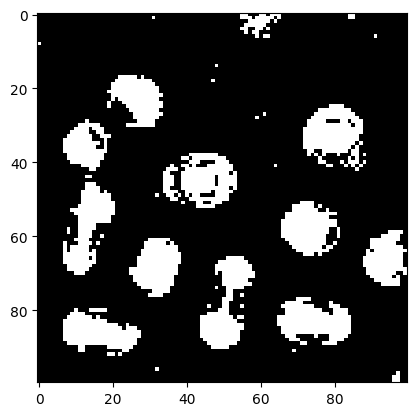

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Assuming `frames` is your list of numpy arrays, each representing a frame
# frames = [...]  # Your list of frames here

fig, ax = plt.subplots()

# Display the first frame to set up the plot.
im = ax.imshow(frames[0], cmap='gray', interpolation='none')

def init():
    # Initialization function: plot the background of each frame
    im.set_data(frames[0])
    return (im,)

def update(frame_number):
    # Update function: this is called for each frame
    im.set_data(frames[frame_number])
    return (im,)

# Create the animation object
# Here, len(frames) is the number of frames you want to animate
ani = FuncAnimation(fig, update, frames=range(len(frames)), init_func=init, blit=True)

# To display the animation in the notebook
HTML(ani.to_jshtml())
